In [1]:
!kaggle datasets download 'crowww/a-large-scale-fish-dataset'

zsh:1: command not found: kaggle


In [2]:
!unzip a-large-scale-fish-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Data

In [1]:
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation, Concatenate
from keras.layers import SeparableConv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input

from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import IoU

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

import PIL
from PIL import ImageOps

import os

import random

In [2]:
input_dir = 'Fish_Dataset/Fish_Dataset'
num_classes = 2
batch_size = 32
img_size = (400, 400)

In [3]:
input_img_paths = []
for paths in os.walk(input_dir):
  dirname = paths[0]
  fnames = paths[1:]
  if not dirname.endswith('GT'):
    for row in fnames:
      for fname in row:
        if fname.endswith('.png') or fname.endswith('.JPG'):
          input_img_paths.append(os.path.join(dirname, fname))

input_img_paths.sort()

print(f'Number of inputs: {len(input_img_paths)}')
for row in input_img_paths[:10]:
  print(row)

Number of inputs: 9000
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00002.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00003.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00004.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00005.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00006.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00007.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00008.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00009.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00010.png


In [4]:
target_img_paths = []
for paths in os.walk(input_dir):
  dirname = paths[0]
  fnames = paths[1:]
  if dirname.endswith('GT'):
    for row in fnames:
      for fname in row:
        if fname.endswith('.png') or fname.endswith('.JPG'):
          target_img_paths.append(os.path.join(dirname, fname))

target_img_paths.sort()

print(f'Number of targets: {len(target_img_paths)}')
for row in target_img_paths[:10]:
  print(row)

Number of targets: 9000
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00001.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00002.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00003.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00004.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00005.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00006.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00007.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00008.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00009.png
Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00010.png


In [3]:
def display_image(img, label=False):
  plt.figure()
  if label==False:
    plt.imshow(img)
  else:
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.show()

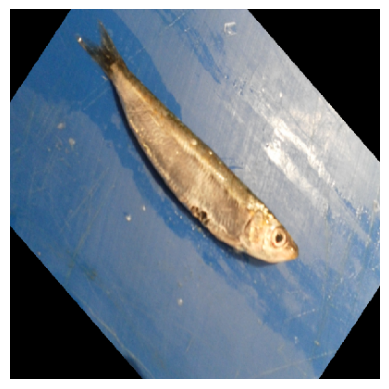

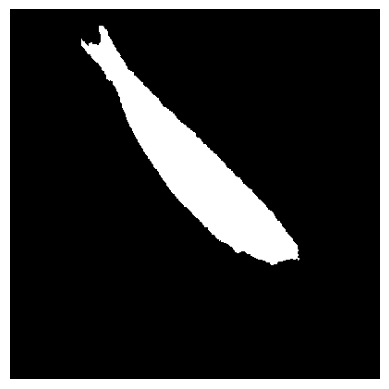

In [6]:
img = load_img(input_img_paths[6], target_size=img_size)
display_image(img_to_array(img, dtype='uint8'))
trg = PIL.ImageOps.autocontrast(load_img(target_img_paths[6], target_size=img_size))
display_image(img_to_array(trg, dtype='uint8'), label=True)

In [2]:
class FishData(Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths)//self.batch_size

  def __getitem__(self, idx):
    i = idx*self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]

    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img_to_array(img).astype('float32')/255

    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = img_to_array(img)//255

    return x, y

NameError: name 'Sequence' is not defined

In [8]:
def get_model(img_size, num_classes):
  inputs = Input(shape=img_size + (3,))
  x = Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residuals = []
  for filters in 64, 128, 256:
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    residuals.append(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

  for filters in 256, 128, 64:
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2DTranspose(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    residual = residuals[-1]
    x = Concatenate(axis=3)([x, residual])
    residuals.pop(-1)

  x = Activation('relu')(x)
  x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)

  outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
  model = Model(inputs, outputs)
  return model

In [9]:
model = get_model(img_size, num_classes)

In [10]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

In [11]:
train_gen = FishData(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = FishData(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [13]:
callbacks = ModelCheckpoint('fish_segmentation.keras', save_best_only=True)
epochs=15
H = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
val_preds = model.predict(val_gen)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 701ms/step - loss: 0.1263 - val_loss: 1.0256
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 701ms/step - loss: 0.0446 - val_loss: 0.4903
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 699ms/step - loss: 0.0409 - val_loss: 0.0479
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 699ms/step - loss: 0.0375 - val_loss: 0.0366
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 701ms/step - loss: 0.0343 - val_loss: 0.0396
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 705ms/step - loss: 0.0331 - val_loss: 0.0316
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 178s 700ms/step - loss: 0.0296 - val_loss: 1.7418
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 700ms/step - loss: 0.0325 - val_loss: 0.0346
Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 704ms/step - loss: 0.0273 - val_loss: 0.0300
Epoch 10/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 703ms/step - loss: 0.0244 - val_loss: 0.0371
Epoch 11/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 703ms/step - loss: 0.0234 - val_loss: 0.0364
Epoch 12/15
250/250

In [14]:
def display_mask(i):
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display_image(img_to_array(img, dtype='uint8'), label=True)

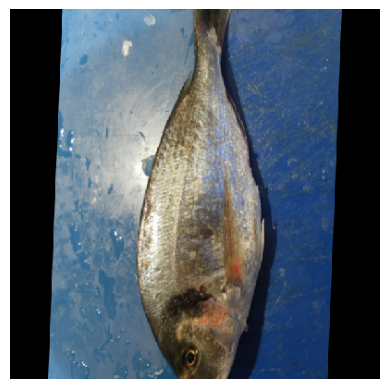

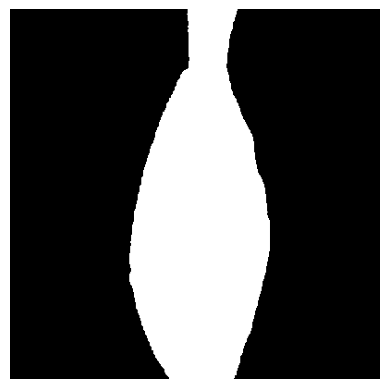

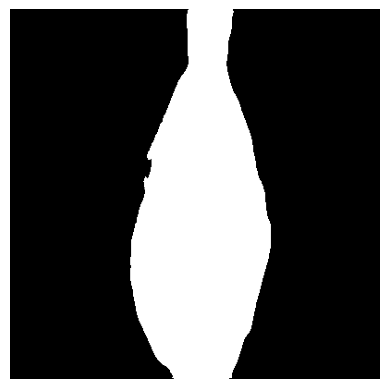

IoU = 0.9697452783584595


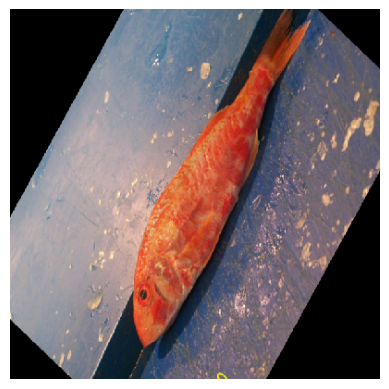

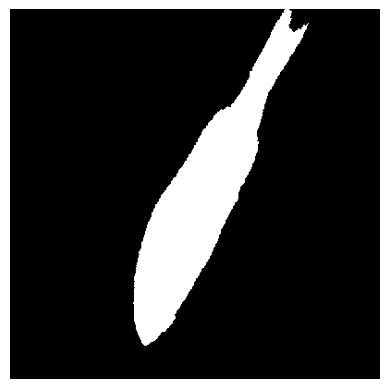

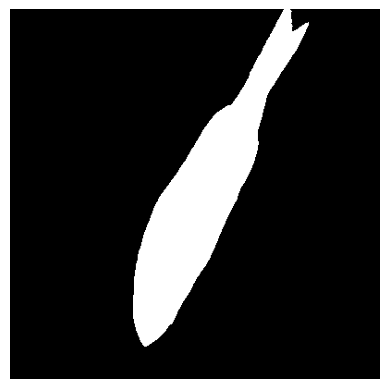

IoU = 0.9753527045249939


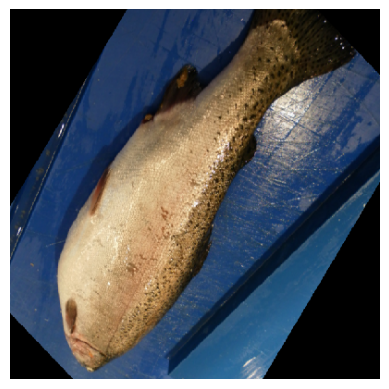

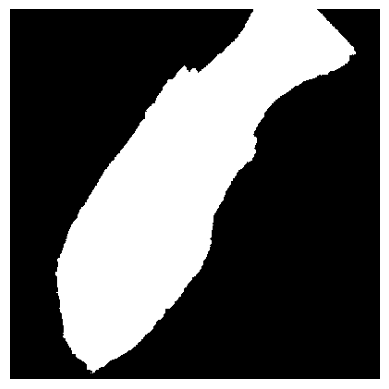

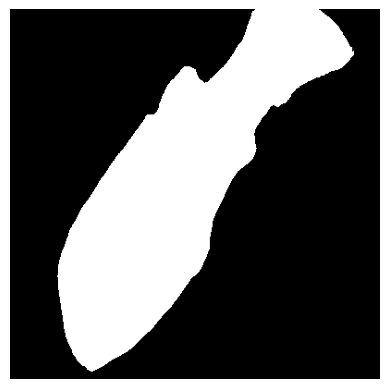

IoU = 0.9604314565658569


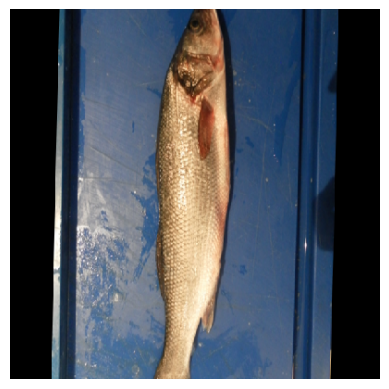

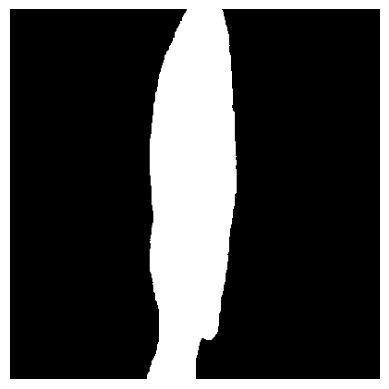

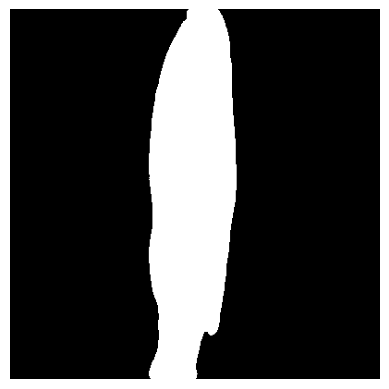

IoU = 0.9796345233917236


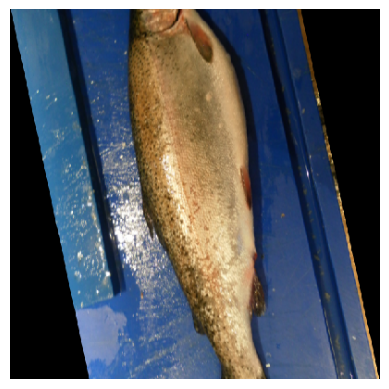

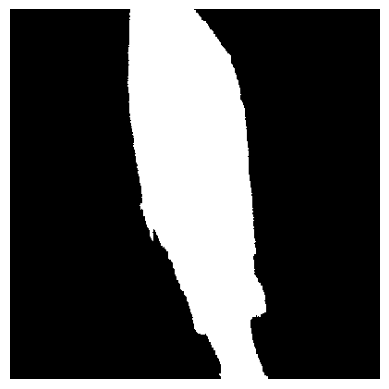

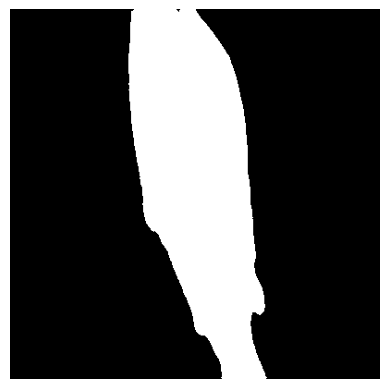

IoU = 0.9822266697883606


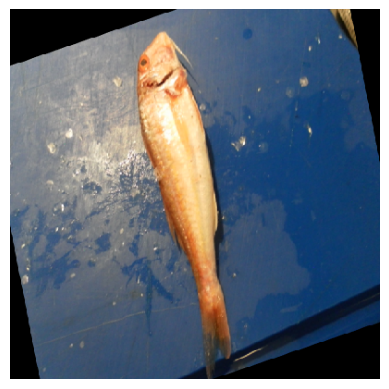

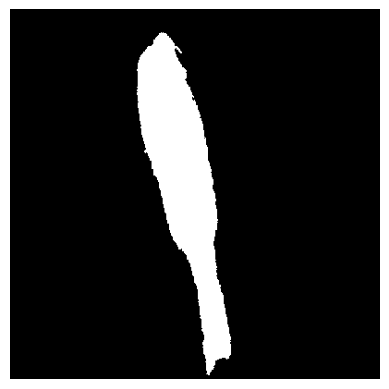

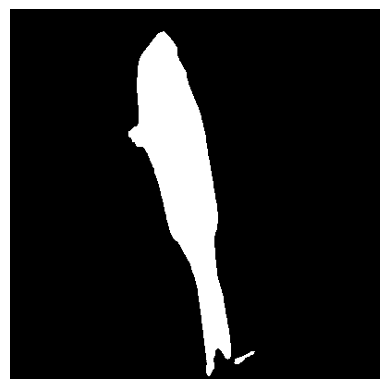

IoU = 0.9433055520057678


In [15]:
iou = IoU(num_classes=2, target_class_ids=[1])
for i in 10, 12, 14, 16, 18, 20:
  img = load_img(val_input_img_paths[i], target_size=img_size)
  display_image(img_to_array(img, dtype='uint8'))
  trg = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i], target_size=img_size,
                                           color_mode='grayscale'))
  display_image(img_to_array(trg, dtype='uint8'), label=True)
  display_mask(i)

  pred = np.argmax(val_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  real = img_to_array(trg, dtype='uint8')//255
  iou.update_state(real, pred)
  print(f'IoU = {iou.result()}')
  iou.reset_state()

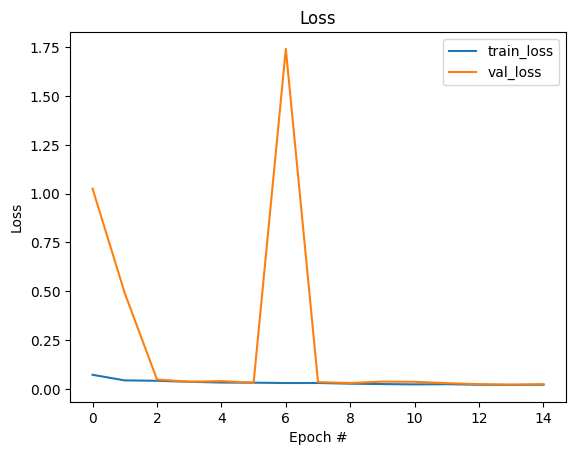

In [16]:
N = np.arange(0, epochs)
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()